# Assignment 2: Scale-Space Blob Detection

### The goal of this assignment is to implement a Laplacian blob detector

Noel Mrowiec
10/1/2024
mrowiec3

In [31]:
# Libraries you will find useful
import numpy as np
import scipy 
import skimage
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageOps 
# for applying the Laplacian filter
from scipy.ndimage.filters import gaussian_laplace, maximum_filter

/tmp/ipykernel_94546/681115042.py:9: DeprecationWarning: Please import `gaussian_laplace` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_laplace, maximum_filter
/tmp/ipykernel_94546/681115042.py:9: DeprecationWarning: Please import `maximum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_laplace, maximum_filter


In [32]:
# Function to globally normalize a 2D array to the range [0, 1] 
def normalize(data):
    return (data - data.min()) / (data.max() - data.min())

In [33]:

# load each image 
dir_path = "images/"
images = []     #color images
filenames = []
for filename in os.listdir(dir_path):
    if filename.endswith('.jpg'):
        filenames.append(filename)
        img_path = os.path.join(dir_path, filename)
        img = Image.open(img_path)
        #img.show()  # This will display the image
        
        # convert images to grayscale
        img_gs = ImageOps.grayscale(img) 
        #img_gs.show()
        img_gs = np.array(img_gs).astype(float)
        img_gs = normalize(img_gs)
        images.append(img_gs)
        

print(f"Loaded {len(images)} images")

Loaded 4 images


In [34]:

def laplacian_gaussian(image, sigmas):
    scale_space = np.empty((image.shape[0],image.shape[1], len(sigmas)))

    for k, sigma in enumerate(sigmas):
        #sigma = get_sigma(k)
        lap_gaus = gaussian_laplace(image, sigma, mode='nearest') 
        scale_norm_LoG = (sigma ** 2) * lap_gaus                                                      #scale normalized
        scale_space[:,:,k] = scale_norm_LoG

    return scale_space

In [35]:
def non_max_suppression_3d(scale_space, sigmas, window_size = 5):

    # Non-maximum suppression in 3D
    footprint = np.ones((window_size, window_size, len(sigmas)))
    local_maxima = (scale_space == maximum_filter(scale_space, footprint=footprint))

    return local_maxima

In [36]:
def get_maxima_coords(scale_space, local_maxima, threshold):
    """
    returns: a list of coordinates of local maxima (x,y,sigma)
    """
    # Get coordinates of the local maxima
    coordinates = np.argwhere(local_maxima)
    
    x_coords, y_coords, z_coords = [], [], []
    # Filter coordinates by the threshold

    #source: Copilot
    for coord in coordinates:
        if scale_space[tuple(coord)] > threshold:
            h, w, d = coord
            x_coords.append(int(w))
            y_coords.append(int(h))
            z_coords.append(int(d))


    return [x_coords, y_coords, z_coords]

In [37]:
# constant
sqt_2 = 2**(1/2)
type(sqt_2)

float

In [38]:
# changing sigma
SIGMAS = [2,4,8,16,32]
coordinates_per_image = []

for image in images:
    lap_of_gauss = laplacian_gaussian(image, SIGMAS)
    #take absolute value
    lap_of_gauss = np.abs(lap_of_gauss)

    #threshold scale space
    threshold = np.percentile(lap_of_gauss, 78)
    # lap_of_gauss = threshold_scale_space(lap_of_gauss, threshold)

    #3D non-maximum suppression
    WINDOW_SIZE = 5
    local_maxima = non_max_suppression_3d(lap_of_gauss, SIGMAS, WINDOW_SIZE)
    coordinates = get_maxima_coords(lap_of_gauss, local_maxima, threshold)
    coordinates_per_image.append(coordinates)

In [39]:
from skimage.transform import resize

In [40]:
import scipy.ndimage

In [41]:
#changing image size
IMAGE_SCALES = [4,8,16,32]
coordinates_per_image_scaled = []


for image in images:
    scale_space = np.empty((image.shape[0],image.shape[1], len(IMAGE_SCALES)))
    #do image scale
    for k, scale in enumerate(IMAGE_SCALES):
        # image_resized = resize(
        #     image, (image.shape[0] // scale, image.shape[1] // scale), anti_aliasing=False
        # )
        # lap_gaus = gaussian_laplace(image_resized, sigma=2, mode='nearest') 

        # Calculate the zoom factor based on the original size
        #zoom_factor = (image.shape[0] / lap_gaus.shape[0], image.shape[1] / lap_gaus.shape[1])

        # Zoom the Laplacian of Gaussian to the original size
        #zoomed_image = scipy.ndimage.zoom(lap_gaus, zoom_factor, order=0)

        #test different one
        
        downsampled_image = scipy.ndimage.zoom(image, 1 / scale)

        # Compute Laplacian of Gaussian
        sigma = 1.4  # Standard deviation for LoG filter
        laplacian_response = np.abs(gaussian_laplace(downsampled_image, sigma))


        zoom_factor = (image.shape[0] / laplacian_response.shape[0], image.shape[1] / laplacian_response.shape[1])
        zoomed_image = scipy.ndimage.zoom(laplacian_response, zoom_factor)
        #end test
        

        scale_space[:,:,k] = zoomed_image


    #now scale_space has all image with LoG
    scale_space = np.abs(scale_space)

    #find threshold scale space
    threshold = np.percentile(scale_space, 95)

    #3D non-maximum suppression
    WINDOW_SIZE = 11
    local_maxima = non_max_suppression_3d(scale_space, IMAGE_SCALES, WINDOW_SIZE)
    coordinates = get_maxima_coords(scale_space, local_maxima, threshold)
    coordinates_per_image_scaled.append(coordinates)


In [42]:


# filtering the image (two implementations)
# one that increases filter size, and one that downsamples the image
# For timing, use time.time()



# To display the detected regions as circle
from matplotlib.patches import Circle
def show_all_circles(image, cx, cy, rad, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, rad):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cy))

    plt.show()

In [43]:
# import numpy as np
# from scipy.ndimage import gaussian_laplace, zoom, maximum_filter
# import matplotlib.pyplot as plt

# def scale_space_blob_detection(image, initial_sigma, k, n):
#     # Original image dimensions
#     original_shape = image.shape

#     # Build Laplacian scale space
#     scalespace = []
#     sigmas = []
#     sigma = initial_sigma
#     current_image = image.copy()

#     for i in range(n):
#         log_image = gaussian_laplace(current_image, sigma=sigma)
#         abs_log_image = np.abs(log_image)
        
#         # Resize the filtered image back to the original size
#         abs_log_image_resized = zoom(abs_log_image, (original_shape[0] / abs_log_image.shape[0], 
#                                                      original_shape[1] / abs_log_image.shape[1]))
        
#         scalespace.append(abs_log_image_resized)
#         print(f"sigma= {sigma}")
#         sigmas.append(sigma)
        
#         # Downsample the image by a factor of 1/k
#         current_image = zoom(image, 1 / (k ** (i + 1)))
#         sigma *= k

#     print(sigmas)

#     # Convert scale space to a numpy array
#     scalespace = np.stack(scalespace, axis=-1)

#     print(f"z of scalespace {scalespace.shape}")

#     # Perform 3D non-maximum suppression
#     footprint = np.ones((3, 3, scalespace.shape[-1]))
#     local_maxima = (scalespace == maximum_filter(scalespace, footprint=footprint))

#     # Get coordinates of the local maxima
#     coordinates = np.argwhere(local_maxima)

#     # Calculate 80th percentile threshold to filter
#     threshold = np.percentile(scalespace, 80)
#     filtered_coords = [coord for coord in coordinates if scalespace[tuple(coord)] > threshold]

#     # Separate x, y, and sigma coordinates
#     x_coords, y_coords, sigma_coords = [], [], []

#     print(filtered_coords[99])

#     for coord in filtered_coords:
#         x, y, cz = coord
#         x_coords.append(x)
#         y_coords.append(y)
        
#         radii = cz
#         print(cz)
#         sigma_coords.append(radii)

#     return np.array(x_coords), np.array(y_coords), np.array(sigma_coords)

# # Example usage
# image = images[0]
# initial_sigma = 4.0
# k = 1.6
# n = 10

# x_coords, y_coords, sigma_coords = scale_space_blob_detection(image, initial_sigma, k, n)

# # Display results
# plt.imshow(image, cmap='gray')
# plt.scatter(y_coords, x_coords, s=sigma_coords*10, facecolors='none', edgecolors='r')
# plt.title('Scale-Space Blob Detection')
# plt.show()


In [44]:
# TODO uncomment!

# print(f"image size {images[0].shape}")
# print(f"num of images {len(coordinates_per_image)}")

# for i, coords in enumerate(coordinates_per_image):
   
#     cx, cy, cz = coords
#     sigmas = np.array([SIGMAS[z] for z in cz])
#     radii = sigmas * sqt_2
#     radii = radii.tolist()

#     print(f"x :{type(cx[0])}, y {type(cy[0])}, radii {type(radii[0])}")
#     show_all_circles(images[i], cx, cy, radii)
# #show_all_circles(images[0], [55,33,88,10], [76,350,12,100], [5,7,1,2])

image size (356, 493)
num of images 4
x :<class 'int'>, y <class 'int'>, radii <class 'float'>


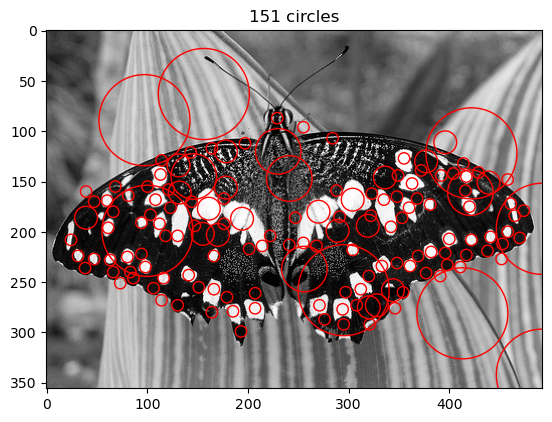

x :<class 'int'>, y <class 'int'>, radii <class 'float'>


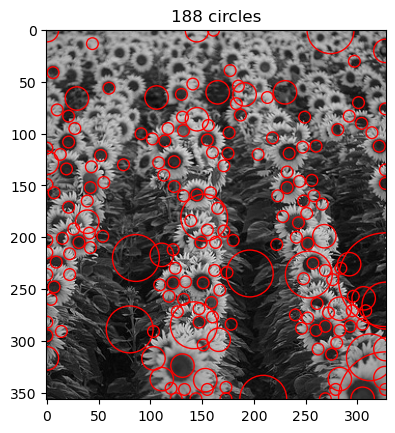

x :<class 'int'>, y <class 'int'>, radii <class 'float'>


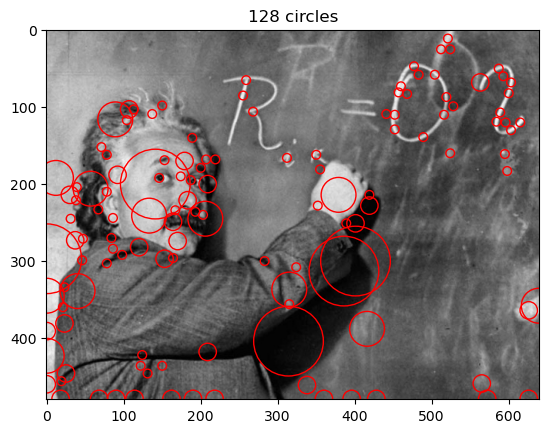

x :<class 'int'>, y <class 'int'>, radii <class 'float'>


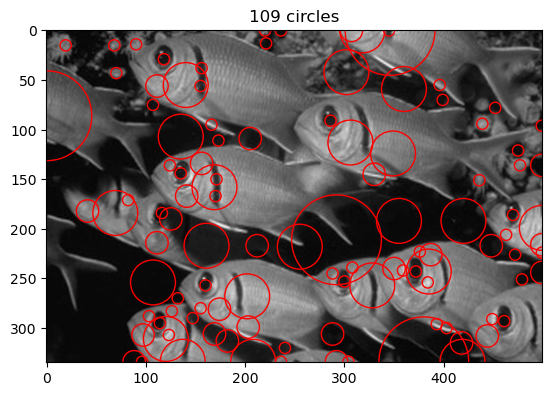

In [45]:
#scaled images

print(f"image size {images[0].shape}")
print(f"num of images {len(coordinates_per_image_scaled)}")

for i, coords in enumerate(coordinates_per_image_scaled):
   
    cx, cy, cz = coords
    sigmas = np.array([IMAGE_SCALES[z] for z in cz])
    radii = sigmas * sqt_2
    radii = radii.tolist()

    print(f"x :{type(cx[0])}, y {type(cy[0])}, radii {type(radii[0])}")
    show_all_circles(images[i], cx, cy, radii)